In [1]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/train'

length_list = []
valence_values=[]

recordings = []

for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            if data['valence'] != 2.333 and len(data['audio_data']) < 91000:
                length_list.append(len(data['audio_data']))
                valence_values.append(data['valence'])
                recordings.append(data['audio_data'])

valence_values = np.array(valence_values)
len(recordings)

100%|██████████| 10557/10557 [00:59<00:00, 177.65it/s]


10391

In [2]:
def round_to_nearest_quarter(number):
    # Assuming 'number' could be a numpy array with a single value
    if isinstance(number, np.ndarray) and number.size == 1:
        number = number.item()  # Convert single-item array to scalar
    
    # Ensure the number is within the 1 to 5 range before processing
    number = np.clip(number, 1, 5)
    # Scale number to shift quarters to whole numbers, round, and rescale
    rounded_number = np.round(number * 4) / 4
    # Clip again to ensure no out-of-range values after rounding
    rounded_number = np.clip(rounded_number, 1, 5)
    return str(rounded_number)

# Pre-process data

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader


from sklearn.model_selection import train_test_split




############################################################################################################
# Pad the recordings to have the same length
max_length = max(len(array) for array in recordings)  # Find the maximum length

# Pad each array to have the maximum length
padded_arrays = np.array([np.pad(array, (0, max_length - len(array)), mode='constant') for array in recordings])


############################################################################################################
# Split the data and labels into training and testing sets
X_train, X_test_help, y_train, y_test_help = train_test_split(padded_arrays, valence_values, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test_help, y_test_help, test_size=0.5, random_state=42)



############################################################################################################
# Create a DataLoader for the training set, test set, and validation set

batch_size = 256  # You can adjust the batch size depending on your system's capability

# Convert input data and labels to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float32 for labels

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

############################################################################################################
# Repeat the same process for the test set

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



############################################################################################################
# Repeat the same process for the validation set
X_validation_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_validation_tensor = torch.tensor(y_val, dtype=torch.float32)

validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)




In [4]:
train_loader.dataset.tensors[0].shape, train_loader.dataset.tensors[1].shape

(torch.Size([6234, 1, 90948]), torch.Size([6234]))

In [24]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Set random seed for reproducibility
        torch.manual_seed(42)

        self.layers = nn.ModuleList()

        # Convolutional Layer 1
        self.layers.append(nn.Conv1d(in_channels=1, out_channels=4, kernel_size=3, padding=1))
        self.layers.append(nn.BatchNorm1d(4))
        self.layers.append(nn.MaxPool1d(kernel_size=3))

        self.layers.append(nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3, padding=1))
        self.layers.append(nn.BatchNorm1d(2))
        self.layers.append(nn.MaxPool1d(kernel_size=3))

        self.layers.append(nn.Conv1d(in_channels=2, out_channels=1, kernel_size=3, padding=1))
        self.layers.append(nn.BatchNorm1d(1))
        self.layers.append(nn.MaxPool1d(kernel_size=3))

        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(3368, 1024))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(1024, 1))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            #print(x.shape)
        return x.view(-1)


### CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training Cycle

def train_model(MLP_model, optimizer, num_epochs):
        criterion = nn.MSELoss()
        # Training loop
        for epoch in tqdm(range(num_epochs)):
            total_loss = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = MLP_model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                loss.backward()  # Backward pass

                # Update weights using the step function of our custom ADAM optimizer
                optimizer.step()

                # Store the loss. loss.item() gets the value in a tensor. This only works for scalars.
                total_loss += loss.item()
        
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if epoch > 1:
                print(f'MSE on validation set: {evaluate_model(MLP_model, test_loader,conf=False):.4f}')



def evaluate_model(MLP_model, test_loader,conf=False):
    with torch.no_grad():
        ### Calculate MSE 
        predictions = []
        actuals = []
        actuals_for_cm = []
        rounded_predictions = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = MLP_model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            actuals_for_cm.extend([str(label) for label in labels.cpu().numpy()])
            rounded_predictions.extend([str(round_to_nearest_quarter(output)) for output in outputs.cpu().numpy()])

        predictions = np.array(predictions)
        actuals = np.array(actuals)
        mse = np.mean((predictions - actuals) ** 2)
        print(f'Mean Squared Error: {mse:.4f}')

        # for i in range(10):
        #     print(f"Predictions: {predictions[i]}")
        #     print(f"Actuals: {actuals[i]}")
        #     print(f"Rounded Predictions: {rounded_predictions[i]}")
        
        ##################
        # Confusion Matrix
        ##################
        if conf:
            cm = confusion_matrix(actuals_for_cm, rounded_predictions)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(actuals), yticklabels=np.unique(actuals))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
        

        


In [25]:
modelCNN = CNN().to(device)
optimizer = optim.Adagrad(modelCNN.parameters(), lr=0.01, weight_decay=0.0001)
train_model(modelCNN, optimizer, num_epochs=30)

  3%|▎         | 1/30 [00:06<03:12,  6.63s/it]

Epoch [1/30], Loss: 1766.1932


  7%|▋         | 2/30 [00:13<03:03,  6.54s/it]

Epoch [2/30], Loss: 38.9697
Epoch [3/30], Loss: 88.3097


  7%|▋         | 2/30 [00:20<04:47, 10.28s/it]

Mean Squared Error: 66.3263


TypeError: unsupported format string passed to NoneType.__format__

Mean Squared Error: 66.3263


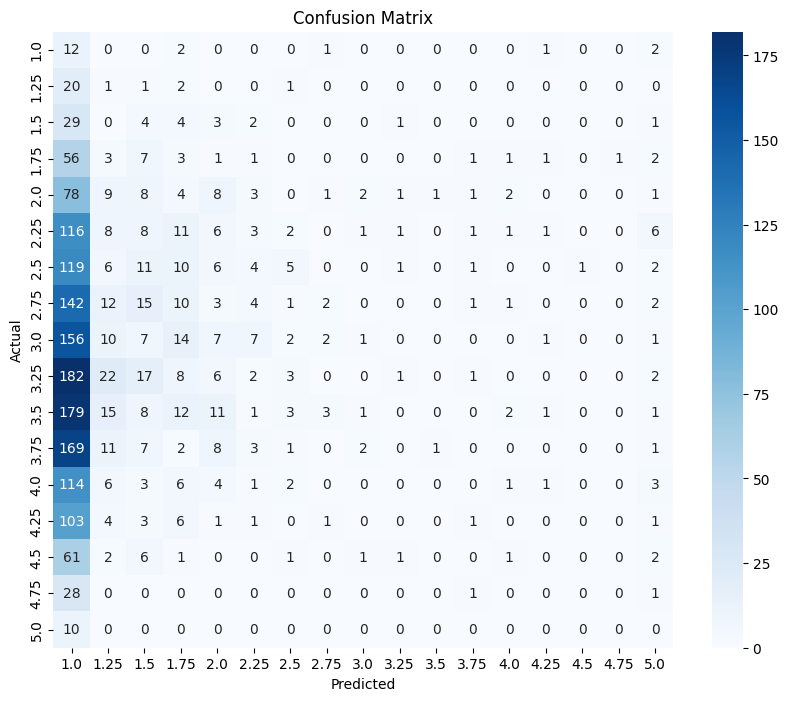

In [22]:
evaluate_model(modelCNN, test_loader,conf=True)